# Building Models in PyMC3

Bayesian inference begins with specification of a probability model relating unknown variables to data. PyMC3 provides the basic building blocks for Bayesian probability models: 

1. stochastic random variables
2. deterministic variables
3. factor potentials. 

A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. The third quantity, the **factor potential**, is *not* a variable but simply a
log-likelihood term or constraint that is added to the joint log-probability to modify it. 

## Example: Inferring patterns in UK coal mining disasters

To motivate this section, let's model a different dataset: a time series of recorded coal mining 
disasters in the UK from 1851 to 1962.

Occurrences of disasters in the time series is thought to be derived from a 
Poisson process with a large rate parameter in the early part of the time 
series, and from one with a smaller rate in the later part. We are interested 
in locating the change point in the series, which perhaps is related to changes 
in mining safety regulations.

In [1]:
import numpy as np

year = np.arange(1851, 1962)
disasters_data = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                         3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                         2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                         1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                         0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                         3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                         0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])

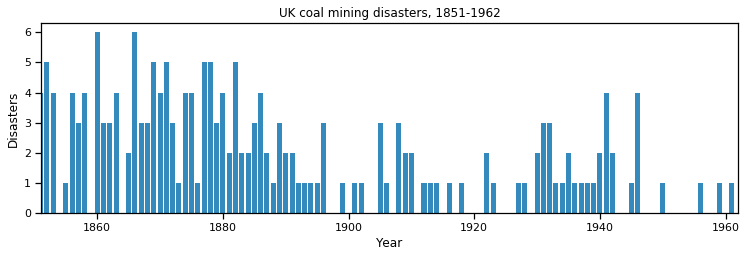

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

fig, ax = plt.subplots(figsize=(12.5, 3.5))
n_count_data = len(disasters_data)
ax.bar(year, disasters_data, color="#348ABD")
ax.set_xlabel("Year")
ax.set_ylabel("Disasters")
ax.set_title("UK coal mining disasters, 1851-1962")
ax.set_xlim(1851, 1962);

We are going to use Poisson random variables for this type of count data. Denoting year $i$'s accident count by $y_i$, 

$$ y_i \sim \text{Poisson}(\lambda)  $$

The modeling problem revolves around estimating the values of the $\lambda$ parameters. Looking at the time series above, it appears that the rate declines later in the time series.

A ***changepoint model*** identifies a point (year) during the observation period (call it $\tau$) after which the parameter $\lambda$ drops to a lower value. So we are estimating two $\lambda$ parameters: one for the early period and another for the late period.

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We need to assign prior probabilities to both $\lambda$ parameters. The gamma distribution not only provides a continuous density function for positive numbers, but it is also **conjugate** with the Poisson sampling distribution. We will specify suitably vague hyperparameters $\alpha$ and $\beta$ for both priors.

$$\begin{aligned}
\lambda_1 &\sim \text{Gamma}( \alpha, \beta ) \cr
\lambda_2 &\sim \text{Gamma}( \alpha, \beta )
\end{aligned}$$

Since we do not have any intuition about the location of the changepoint (prior to viewing the data), we will assign a discrete uniform prior over all years 1851-1962.

$$\begin{aligned}
& \tau \sim \text{DiscreteUniform(1851,1962) }\cr
& \Rightarrow P( \tau = k ) = \frac{1}{111}
\end{aligned}$$

## The FreeRV class

A stochastic variable is represented in PyMC3 by a `FreeRV` class. This structure adds functionality to Theano's `TensorVariable` class, by mixing in the PyMC `Factor` class. A `Factor` is used whenever a variable contributes a log-probability term to a model. Hence, you know a variable is a subclass of `Factor` whenever it has a `logp` method, as we saw in the previous section.

A `FreeRV` object has several important attributes:

`dshape`
:   The variable's shape.

`dsize`
:   The overall size of the variable.

`distribution`
:   The probability density or mass function that describes the distribution of the variable's values.

`logp`
:   The log-probability of the variable's current value given the values
    of its parents.

`init_value`
:   The initial value of the variable, used by many algorithms as a starting point for model fitting.

`model`
:   The PyMC model to which the variable belongs.


### Creation of stochastic random variables

There are two ways to create stochastic random variables (`FreeRV` objects), which we will call the **automatic**, and **manual** interfaces.

#### Automatic

Stochastic random variables with standard distributions provided by PyMC3 can be created in a single line using special subclasses of the `Distribution` class. For example, as we have seen, the uniformly-distributed discrete variable $switchpoint$ in the coal mining disasters model is created using the automatic interface as follows:

In [3]:
from pymc3 import Model, Uniform

with Model() as disaster_model:

    switchpoint = Uniform('switchpoint', lower=0, upper=110)

Similarly, the rate parameters can automatically be given exponential priors:

In [4]:
from pymc3 import Exponential

with disaster_model:
    early_mean = Exponential('early_mean', lam=1)
    late_mean = Exponential('late_mean', lam=1)

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. Continuous variables are represented by a specialized subclass of `Distribution` called `Continuous` and discrete variables by the `Discrete` subclass.

The main differences between these two sublcasses are in the `dtype` attribute (`int64` for `Discrete` and `float64` for `Continuous`) and the `defaults` attribute, which determines which summary statistic to use for initial values when one is not specified ('mode' for `Discrete` and 'median', 'mean', and 'mode' for `Continuous`).

In [5]:
switchpoint.distribution.defaults

('median', 'mean', 'mode')

As we previewed in the introduction, `Distribution` has a class method `dist` that returns a probability distribution of that type, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. This class method allows that.

In [6]:
Exponential.dist(1)

#### Manual

The uniformly-distributed discrete stochastic variable `switchpoint` in the disasters model could alternatively be created from a function that computes its log-probability as follows:

In [7]:
from pymc3 import DensityDist
from pymc3.math import switch

with Model():
    
    def uniform_logp(value, lower=0, upper=111):
        """The switchpoint for the rate of disaster occurrence."""
        return switch((value > upper) | (value < lower), -np.inf, -np.log(upper - lower + 1))

    switchpoint = DensityDist('switchpoint', logp=uniform_logp, dtype='int64')

In [8]:
switchpoint.logp({'switchpoint':4})

array(-4.71849887)

In [9]:
switchpoint.logp({'switchpoint': 44})

array(-4.71849887)

In [10]:
switchpoint.logp({'switchpoint':-1})

array(-inf)

A couple of things to notice: while the function specified for the `logp` argument can be an arbitrary Python function, it must use **Theano operators and functions** in its body. This is because one or more of the arguments passed to the function may be `TensorVariables`, and they must be supported. Also, we passed the value to be evaluated by the `logp` function as a **dictionary**, rather than as a plain integer. By convention, values in PyMC3 are passed around as a data structure called a `Point`. Points in parameter space are represented by dictionaries with parameter names as they keys and the value of the parameters as the values.

To emphasize, the Python function passed to `DensityDist` should compute the *log*-density or *log*-probability of the variable. That is why the return value in the example above is `-log(upper-lower+1)` rather than `1/(upper-lower+1)`.

## The ObservedRV Class

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

Otherwise, observed stochastic random variables are created via the same interfaces as unobserved: **automatic** or **manual**. As an example of an automatic instantiation, consider a Poisson data likelihood :

In [11]:
from pymc3 import Poisson

with disaster_model:
    
    disasters = Poisson('disasters', mu=3, observed=[3,4,1,2,0,2,2])

We have already seen manual instantiation, from the melanoma survial model where the exponential survival likelihood was implemented manually:

```python
def logp(failure, value):
    return (failure * log(lam) - lam * value).sum()

x = DensityDist('x', logp, observed={'failure':failure, 'value':t})
```

Notice in this example that there are two vetors observed data for the likelihood `x`, passed as a dictionary.

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). More on this later.

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents. For example, in our disasters model, `rate` is a deterministic variable.

```python
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))
```

so `rate`'s value can be computed exactly from the values of its parents `early_mean`, `late_mean` and `switchpoint`.

There are two types of deterministic variables in PyMC3

#### Anonymous deterministic variables

The easiest way to create a deterministic variable is to operate on or transform one or more variables in a model directly. For example, the simplest way to specify the `rate` variable above is as follows:

In [12]:
with disaster_model:
    
    rate = switch(switchpoint >= np.arange(112), early_mean, late_mean)

Or, let's say we wanted to use the mean of the `early_mean` and `late_mean` variables somehere in our model:

In [13]:
with disaster_model:
    
    mean_of_means = (early_mean + late_mean)/2

These are called *anonymous* variables because we did not wrap it with a call to `Determinstic`, which gives it a name as its first argument. We simply specified the variable as a Python (or, Theano) expression. This is therefore the simplest way to construct a determinstic variable. The only caveat is that the values generated by anonymous determinstics at every iteration of a MCMC algorithm, for example, are not recorded to the resulting trace. So, this approach is only appropriate for intermediate values in your model that you do not wish to obtain posterior estimates for, alongside the other variables in the model.

#### Named deterministic variables

To ensure that deterministic variables' values are accumulated during sampling, they should be instantiated using the **named deterministic** interface; this uses the `Deterministic` function to create the variable. Two things happen when a variable is created this way:

1. The variable is given a name (passed as the first argument)
2. The variable is appended to the model's list of random variables, which ensures that its values are tallied.


In [14]:
from pymc3 import Deterministic

with disaster_model:
    
    rate = Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))

In [15]:
disaster_model.named_vars

{'switchpoint_interval__': switchpoint_interval__,
 'switchpoint': switchpoint,
 'early_mean_log__': early_mean_log__,
 'early_mean': early_mean,
 'late_mean_log__': late_mean_log__,
 'late_mean': late_mean,
 'disasters': disasters,
 'rate': rate}

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents, for example:

$$p(x_0, x_2, \ldots x_{N-1}) \propto \prod_{i=0}^{N-2} \psi_i(x_i, x_{i+1})$$

In other cases we may want to add probability terms to existing models. For example, suppose we want to constrain the difference between the early and late means in the disaster model to be less than 1, so that the joint density becomes: 

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

We call such log-probability terms **factor potentials** (Jordan 2004). Bayesian
hierarchical notation doesn't accomodate these potentials. 

### Creation of Potentials

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface:

In [16]:
from pymc3 import Potential

with disaster_model:
    
    rate_constraint = Potential('rate_constraint', switch((late_mean - early_mean)>0, -np.inf, 0))

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

## Sampling with MCMC

PyMC's core business is using Markov chain Monte Carlo to fit virtually any probability model. This involves the assignment and coordination of a suite of **step methods**, each of which is responsible for updating one or more variables. 

The user's interface to PyMC's sampling algorithms is the `sample` function:

```python
sample(draws, step=None, start=None, trace=None, chain=0, njobs=1, tune=None, 
        progressbar=True, model=None, random_seed=None)
```

`sample` assigns particular samplers to model variables, and generates samples from them. The `draws` argument
controls the total number of MCMC iterations. PyMC can automate most of the details of sampling, outside of the selection of the number of draws, using default settings for several parameters that control how the sampling is set up and conducted. However, users may manually intervene in the specification of the sampling by passing values to a number of keyword argumetns for `sample`.

### Assigning step methods

The `step` argument allows users to assign a MCMC sampling algorithm to the entire model, or to a subset of the variables in the model. For example, if we wanted to use the Metropolis-Hastings sampler to fit our model, we could pass an instance of that step method to `sample` via the `step` argument:

```python
with my_model:

    trace = sample(1000, step=Metropolis())
```

or if we only wanted to assign `Metropolis` to a parameter called `β`:

```python
with my_model:

    trace = sample(1000, step=Metropolis(vars=[β]))
```

When `step` is not specified by the user, PyMC3 will assign step methods to variables automatically. To do so, each step method implements a class method called `competence`. This method returns a value from 0 (incompatible) to 3 (ideal), based on the attributes of the random variable in question. `sample` assigns the step method that returns the highest competence value to each of its unallocated stochastic random variables. In general:

* Binary variables will be assigned to `BinaryMetropolis` (Metropolis-Hastings for binary values)
* Discrete variables will be assigned to `Metropolis`
* Continuous variables will be assigned to `NUTS` (No U-turn Sampler)

### Starting values

The `start` argument allows for the specification of starting values for stochastic random variables in the model. MCMC algorithms begin by initializing all unknown quantities to arbitrary starting values. Though in theory the value can be any value under the support of the distribution describing the random variable, we can make sampling more difficult if an initial value is chosen in the extreme tail of the distribution, for example. If starting values are not passed by the user, default values are chosen from the mean, median or mode of the distribution.

As suggested in the previous section on approximation methods, it is sometimes useful to initialize a MCMC simulation at the maximum *a posteriori* (MAP) estimate:

In [17]:
with Model() as disaster_model:

    switchpoint = Uniform('switchpoint', lower=year.min(), upper=year.max())
    early_mean = Exponential('early_mean', lam=0.5)
    late_mean = Exponential('late_mean', lam=0.5)

    rate = switch(switchpoint >= year, early_mean, late_mean)
    
    disasters = Poisson('disasters', rate, observed=disasters_data)

In [18]:
from pymc3 import find_MAP

with disaster_model:
    
    start = find_MAP()

/home/fonnesbeck/anaconda3/envs/mcmc_tutorial/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -213.77, ||grad|| = 68.219: 100%|██████████| 9/9 [00:00<00:00, 754.51it/s]


In [19]:
start

{'switchpoint_interval__': array(0.),
 'early_mean_log__': array(0.91451801),
 'late_mean_log__': array(-0.1043578),
 'switchpoint': array(1906.),
 'early_mean': array(2.49557212),
 'late_mean': array(0.9009029)}

In [20]:
from pymc3 import sample, Metropolis

with disaster_model:
    trace = sample(100, step=Metropolis(), cores=2, start=start)

Only 100 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [late_mean]
>Metropolis: [early_mean]
>Metropolis: [switchpoint]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:00<00:00, 1748.18draws/s]
The number of effective samples is smaller than 25% for some parameters.


If we are sampling more than one Markov chain from our model, it is often recommended to initialize each chain to different starting values, so that lack of convergence can be more easily detected (see *Model Checking* section). 

### Storing samples

Notice in the above call to `sample` that output is assigned to a variable we have called `trace`. 

In [21]:
trace

<MultiTrace: 2 chains, 100 iterations, 6 variables>

This `MultiTrace` object is a data structure that stores the samples from an MCMC run in a tabular structure. By default, `sample` will create a new `MultiTrace` object that stores its samples in memory, as a NumPy `ndarray`. We can override the default behavior by specifying the `trace` argument. There are three options:

1. Selecting an alternative database backend to keeping samples in an `ndarray`. Passing either "text" or "sqlite", for example, will save samples to text files or a SQLite database, respectively. An instance of a backend can also be passed.
2. Passing a list of variables will only record samples for the subset of variables specified in the list. These will be stored in memory.
3. An existing `MultiTrace` object. This will add samples to an existing backend.


In [22]:
with disaster_model:
    db_trace = sample(100, tune=0, cores=2, trace='sqlite')

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [late_mean, early_mean, switchpoint]
Sampling 2 chains: 100%|██████████| 200/200 [00:00<00:00, 1138.51draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [23]:
!rm mcmc.sqlite

### Parallel sampling

Nearly all modern desktop computers have multiple CPU cores, and running multiple MCMC chains is an **embarrasingly parallel** computing task. It is therefore relatively simple to run chains in parallel in PyMC3. This is done by setting the `cores` argument in `sample` to some value between 2 and the number of cores on your machine (you can specify more chains than cores, but you will not gain efficiency by doing so). The default value of `cores` is `None`, which will select the number of CPUs on your machine, to a maximum of 4. 

> Keep in mind that some chains might themselves be multithreaded via openmp or BLAS. In those cases it might be faster to set this to 1.

By default, PyMC3 will run a sample a minimum of 2 and a maximum of `cores` chains. However, the number of chains sampled can be set independently of the number of cores by specifying the `chains` argument.

In [24]:
with disaster_model:
    ptrace = sample(100, tune=100, chains=4, cores=2)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [late_mean, early_mean, switchpoint]
Sampling 4 chains: 100%|██████████| 800/800 [01:00<00:00,  6.07draws/s]
The acceptance probability does not match the target. It is 0.5286333447366897, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.5574995647709398, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.5617403175489052, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, i

Running $n$ iterations with $c$ chains will result in $n \times c$ samples.

In [25]:
ptrace['early_mean'].shape

(400,)

If you want to specify different arguments for each chain, a list of argument values can be passed to `sample` as appropriate. For example, if we want to initialize random variables to particular (*e.g.* dispersed) values, we can pass a list of dictionaries to `start`:

In [26]:
with disaster_model:
    ptrace = sample(10, tune=100, cores=2, discard_tuned_samples=False, init=None,
                    start=[{'early_mean':0.1}, {'early_mean':10}]) 

Only 10 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [late_mean, early_mean, switchpoint]
Sampling 2 chains: 100%|██████████| 220/220 [00:07<00:00, 28.22draws/s]
/home/fonnesbeck/anaconda3/envs/mcmc_tutorial/lib/python3.7/site-packages/pymc3/sampling.py:464: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.4240191476955976, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


In [27]:
[chain[:5] for chain in ptrace.get_values('early_mean', combine=False)]

[array([1.38481639, 1.38481639, 4.46040266, 4.53289822, 2.81074373]),
 array([10.        , 10.        ,  5.35720418,  4.57184243,  3.34497226])]

Generating several chains is generally recommended because it aids in model checking, allowing statistics such as the potential scale reduction factor ($\hat{R}$) and effective sample size to be calculated.

## Step methods

Step method classes handle individual stochastic variables, or sometimes groups of them. They are responsible for making the variables they handle take **single MCMC steps** conditional on the rest of the model. Each PyMC step method (usually subclasses of `ArrayStep`) implements a method called `astep()`, which is called iteratively by `sample`. 

All step methods share an optional argument `vars` that allows a particular subset of variables to be handled by the step method instance. Particular step methods will have additional arguments for setting parameters and preferences specific to that sampling algorithm.

> NB: when a PyMC function or method has an argument called `vars` it is expecting a list of variables (*i.e.* the variables themselves), whereas arguments called `varnames` expect a list of variables names (*i.e.* strings)

### HamiltonianMC

The Hamiltonian Monte Carlo algorithm is implemented in the `HamiltonianMC` class. Being a gradient-based sampler, it is only suitable for **continuous random variables**. Several optional arguments can be provided by the user. The algorithm is **non-adaptive**, so the parameter values passed at instantiation are fixed at those values throughout sampling.

`HamiltonianMC` requires a scaling matrix parameter `scaling`, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although it is used somewhat differently here. The matrix gives an approximate shape of the posterior distribution, so that `HamiltonianMC` does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. 

Fortunately, `HamiltonianMC` can often make good guesses for the scaling parameters. If you pass a point in parameter space (as a dictionary of variable names to parameter values, the same format as returned by `find_MAP`), it will look at the **local curvature** of the log posterior-density (the diagonal of the Hessian matrix) at that point to guess values for a good scaling vector, which can result in a good scaling value. Also, the MAP estimate is often a good point to use to initiate sampling. 

- `scaling` 
: Scaling for momentum distribution. If a 1-dimensional array is passed, it is interpreted as a matrix diagonal.
            
- `step_scale` 
: Size of steps to take, automatically scaled down by $1/n^{0.25}$. Defaults to .25.
            
- `path_length` 
: total length to travel during leapfrog. Defaults to 2.
            
- `is_cov` 
: Flag for treating scaling as a covariance matrix/vector, if True. Treated as precision otherwise.
            
- `step_rand` 
: A function which takes the step size and returns an new one used to randomize the step size at each iteration.


### NUTS

A disadgantage of the HMC sampler is that there are key hyperparameters that require tuning for sampling to proceed efficiently. Hoffman and Gelman (2014) developed an auto-tuning variant of HMC that takes care of selecting path lengths and step sizes.

`NUTS` is the No U-turn Sampler of Hoffman and Gelman (2014), an adaptive version of Hamiltonian MC that **automatically tunes** the step size and number on the fly. NUTS uses a recursive algorithm to build a set of likely candidate points that spans a wide swath of the target distribution. True to its name, it stops automatically when it starts to double back and retrace its steps.

The algorithm employs **binary doubling**, which takes leapfrog steps alternating in direction with respect to the initial gradient. That is, one step is taken in the forward direction, two in the reverse direction, then four, eight, etc. The result is a balanced, binary tree with nodes comprised of Hamiltonian states. 

![](images/binary_doubling.png)

Doubling process builds a balanced binary tree whose leaf nodes correspond to
position-momentum states. Doubling is halted when the subtrajectory from the
leftmost to the rightmost nodes of any balanced subtree of the overall binary tree starts to double back on itself

![](images/uturn.png)

To ensure detailed balance, a slice variable is sampled from:

$$ u \sim \text{Uniform}(0, \exp[L(\theta) - 0.5 r \cdot r])$$

where $r$ is the initial momentum vector. The next sample is then chosen uniformly from the points in the remaining balanced tree.

In addition to the arguments to `HamiltonianMC`, `NUTS` takes additional parameters to controls the tuning. The most important of these is the target acceptance rate for the Metropolis acceptance phase of the algorithm, `taget_accept`. 
Sometimes if the NUTS struggles to sample efficiently, changing this parameter above the default target rate of 0.8 will improve sampling (the original recommendation by Hoffman & Gelman was 0.6). Increasing the rate very high will also make the sampler more conservative, however, taking many small steps at every iteration. 


In [28]:
with disaster_model:
    trace_99 = sample(100, tune=200, cores=2, target_accept=0.99)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [late_mean, early_mean, switchpoint]
Sampling 2 chains: 100%|██████████| 600/600 [00:36<00:00,  7.88draws/s]
The acceptance probability does not match the target. It is 0.9665921540379762, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


There is rarely a reason to use `HamiltonianMC` rather than `NUTS`. It is the default sampler for continuous variables in PyMC3.

### Metropolis

``Metropolis`` implements a Metropolis-Hastings step, as described the theory section, and is designed to handle float- and integer-valued variables.

A `Metropolis` step method can be instantiated with any of several optional arguments:


- `S`
:   This sets the proposal standard deviation or covariance matrix.

- `proposal_dist`
:   A function that generates zero-mean random deviates used as proposals. Defaults to the normal distribution.

- `scaling`
:   An initial scale factor for the proposal

- `tune_interval`
:   The number of intervals between tuning updates to `scaling` factor.

When the step method is instantiated, the `proposal_dist` is parameterized with the value passed for `S`. While sampling, the value of `scaling` is used to scale the value proposed by `proposal_dist`, and this value is tuned throughout the MCMC run. During tuning, the acceptance ratio of the step method is examined, and this scaling factor
is updated accordingly. Tuning only occurs when the acceptance rate is **lower than 20%** or **higher than 50%**; rates between 20-50% are considered optimal for Metropolis-Hastings sampling. The default tuning interval (`tune_interval`) is 100 iterations.

Although tuning will continue throughout the sampling loop, it is important to verify that the
**diminishing tuning** condition of [Roberts and Rosenthal (2007)](http://projecteuclid.org/DPubS?service=UI&version=1.0&verb=Display&handle=euclid.jap/1183667414) is satisfied: the
amount of tuning should decrease to zero, or tuning should become very infrequent.

`Metropolis` handles discrete variable types automatically by rounding the proposed values and casting them to integers.

### BinaryMetropolis

While binary (boolean) variables can be handled by the `Metropolis` step method, sampling will be very inefficient. The `BinaryMetropolis` class is optimized to handle binary variables, by one of only two possible values. The only tuneable parameter is the `scaling` argument, which is used to vary the Bernoulli probability:

    p_jump = 1. - .5 ** self.scaling

This value is compared to pseudo-random numbers generated by the step method, to determine whether a 0 or 1 is proposed.

`BinaryMetropolis` will be automatically selected for random variables that are distributed as Bernoulli, or categorical with only 2 categories.

### Slice

Though the Metropolis-Hastings algorithm is easy to implement for a variety of models, its efficiency is poor. We have seen that it is possible to tune Metropolis samplers, but it would be nice to have a "black-box" method that works for arbitrary continuous distributions, which we may know little about a priori.

The **slice sampler** (Neal 2003) improves upon the Metropolis sampler by being both efficient and easy to program generally. The idea is to first sample from the conditional distribution for $y$ (i.e., $Pr(x)$) given some current value of $x$, which is uniform over the $(0,f(x))$, and conditional on this value for $y$, then sample $x$, which is uniform on $S = {x : y < f (x)}$.

The steps required to perform a single iteration of the slice sampler to update the current value of $x_i$ is as follows:

1. Sample $y$ uniformly on (0,f(xi)).
2. Use this value $y$ to define a horizontal *slice* $S = {x : y < f (x)}$.
3. Establish an interval, I=(xa,xb), around xi that contains most of the slice.
4. Sample $x_{i+1}$ from the region of the slice overlaping I.

Hence, slice sampling employs an **auxilliary variable** ($y$) that is not retained at the end of the iteration. Note that in practice one may operate on the log scale such that $g(x) = \log(f (x))$ to avoid floating-point underflow. In this case, the auxiliary variable becomes $z = log(y) = g(x_i) − e$, where $e \sim \text{Exp}(1)$, resulting in the slice $S = \{x : z < g(x)\}$.

There are many ways of establishing and sampling from the interval $I$, with the only restriction being that the resulting Markov chain leaves $f(x)$ **invariant**. The objective is to include as much of the slice as possible, so that the potential step size can be large, but not (much) larger than the slice, so that the sampling of invalid points is minimized. Ideally, we would like it to be the slice itself, but it may not always be feasible to determine (and certainly not automatically).

In PyMC3, the `Slice` class implements the **univariate** slice sampler. It is suitable for univariate, continuous variables. There is a single user-defined parameter `w`, which sets the width of the initial slice. If not specified, it defaults to a width of 1.

In [29]:
from pymc3 import Slice

with disaster_model:
    
    slice_trace = sample(2000, cores=2, step=Slice())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [late_mean]
>Slice: [early_mean]
>Slice: [switchpoint]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:07<00:00, 705.79draws/s]


In [30]:
plot_trace(slice_trace, var_names=['early_mean','late_mean']);

NameError: name 'plot_trace' is not defined

---

## To Learn More

- Hoffman MD, Gelman A. 2014. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 15(1):1593-1623.
- M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
- Neal, R. M. 2003. Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198